# INFO 3950 ps2

name: Kate Li

netid: kl739

In [3]:
#setup for inline plotting
import re
import matplotlib.pyplot as plt, numpy as np
%matplotlib inline
from collections import Counter, defaultdict
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [4]:
from glob import glob

pos_files = sorted(glob("review_polarity/txt_sentoken/pos/*.txt"))
neg_files = sorted(glob("review_polarity/txt_sentoken/neg/*.txt"))

pos_reviews = [open(file, 'r', encoding='latin-1').read() for file in pos_files]
neg_reviews = [open(file, 'r', encoding='latin-1').read() for file in neg_files]
reviews = pos_reviews + neg_reviews

print(f"Number of Positive Reviews: {len(pos_reviews)}")
print(f"Number of Negative Reviews: {len(neg_reviews)}")
print(f"Number of Total Reviews: {len(reviews)}")

Number of Positive Reviews: 1000
Number of Negative Reviews: 1000
Number of Total Reviews: 2000


## 1) Sentiment Analysis
### Part A
For features in this part, use a vocabulary of the 1000 words that occur in the largest number of the 2000 documents. (This may seem like cheating, since we're building a vocabulary before the train/test split, so "seeing" aspects of the validation set. But the top 1000 words all occur in well over 100 of the documents, so would be roughly the same regardless of which 90% is chosen as the training set for any 90/10 split.) The very top words will all be non-discriminating stopwords (the, of, and, ...), but we'll leave them in. Construct a 2000x1000 array X_data with the features for the 1000 negative reviews plus 1000 positive reviews.

In [6]:
# Function for tokenizing text
def words(txt): 
    return re.findall(r"['\w]+", txt.lower())

In [7]:
# Counting word frequencies across texts
pos_count = Counter()
for p in pos_reviews:
    for w in set(words(p)):
        pos_count[w]+=1

neg_count = Counter()
for n in neg_reviews:
    for w in set(words(n)):
        neg_count[w]+=1

reviews_count = pos_count + neg_count

Nf = 1000  # 1000 most common words
Nfvocab, Nfn = zip(*reviews_count.most_common(Nf))
set_vocab = Nfvocab

In [8]:
# Construct X_data
word_index = {w:k for k, w in enumerate(set_vocab)}  # a dictionary where the value for each key is the index of that word in top_1000

# Function for feature selection -- returns an array of 0's and 1's
def features(txt):
    f = np.zeros(Nf)
    for w in set(words(txt)) & set(set_vocab):
        f[word_index[w]] = 1
    return f

X_data = np.array([features(r) for r in neg_reviews+pos_reviews])
print(X_data.shape)

y_data = np.array([0]*1000 + [1]*1000)

(2000, 1000)


**i) What is the score using `X_test = np.concatenate([X_data[600:700],X_data[1600:1700]])` (and training on the other 1800 texts)? This should turn out to be a "lucky" split.**

In [10]:
X_train = np.concatenate([X_data[:600], X_data[700:1600], X_data[1700:]])
y_train = np.concatenate([y_data[:600], y_data[700:1600], y_data[1700:]])

X_test = np.concatenate([X_data[600:700], X_data[1600:1700]])
y_test = np.concatenate([y_data[600:700], y_data[1600:1700]])

clf = BernoulliNB(alpha = 0.5)
clf.fit(X_train, y_train).score(X_test, y_test)

0.835

**ii) What is the score using `X_test = np.concatenate([X_data[300:400], X_data[1300:1400]])` (and training on the other 1800 texts)? This should turn out to be an "unlucky" split.**

In [12]:
X_train = np.concatenate([X_data[:300], X_data[400:1300], X_data[1400:]])
y_train = np.concatenate([y_data[:300], y_data[400:1300], y_data[1400:]])

X_test = np.concatenate([X_data[300:400], X_data[1300:1400]])
y_test = np.concatenate([y_data[300:400], y_data[1300:1400]])

clf.fit(X_train, y_train).score(X_test, y_test)

0.75

**iii) Use the scikit-learn `cross_val_score()` with `cv=10` to find the scores for the 10 successive stratified splits. What is the mean test score? (It should be close to 80%). Plot the ten training and test scores as in the last cell of lec7.ipynb, except both on the same graph (instead of two subplots).**

In [14]:
# Use cross validation with cv = 10 to find the scores for the 10 successive stratigied splits and then found the mean score
output = cross_val_score(clf, X_data, y_data, cv = 10)
print(round(output.mean(), 2))

0.79


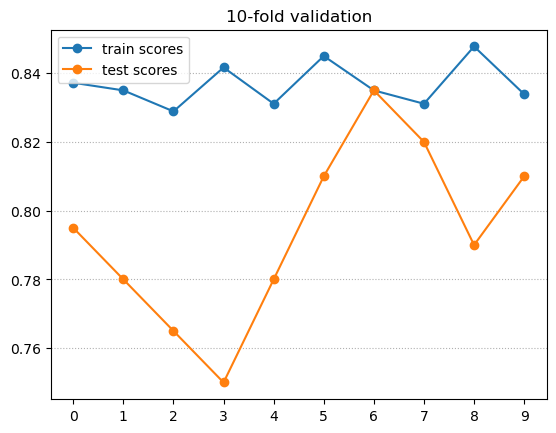

In [15]:
# Plot the ten training and test scores
output = cross_validate(clf, X_data, y_data, return_train_score = True, cv = 10)
plt.plot(range(10),output['train_score'], 'o-', label='train scores')
plt.plot(range(10),output['test_score'], 'o-', label='test scores')
plt.title('10-fold validation')
plt.xticks(range(10))
plt.grid(axis='y', linestyle='dotted')
plt.legend()

### Part B
As in ps1, the above feature set, of the 1000 most frequent terms, might not be optimal for this classification task, since many of those terms (the, of, and, or, ...) may not discriminate systematically between positive and negative reviews. They could just add noise and have an adverse effect on classifier performance. We can again try to use the terms that are most discriminating, in the sense of having the largest disparities in numbers of occurrences between the positive and negative sets, as was illustrated in lec4.ipynb for the biology/physics classifier.

**i) List the top 20 terms most discriminating in the negative direction (highest ratio (.5 + #negtexts with word)/(.5 + #postexts with word)), and the top 20 most discriminating in the positive direction (highest reciprocal of above ratio). This is just to get a feeling for what the typical words look like.**

In [18]:
# ratio is the equation given in the question
ratio = {w: (0.5 + neg_count[w]) / (0.5 + pos_count[w]) for w in reviews_count}

# neg_discrim is the top words discriminating in the negative direction (greater ratio so reverse = True)
neg_discrim = sorted(ratio, key = ratio.get, reverse = True)
print(f"top 20 negative words: {neg_discrim[:20]}")

# pos_discrim is the top words discriminating in the positive direction (smaller ratio so reverse = False)
pos_discrim = sorted(ratio, key = ratio.get)
print(f"top 20 positive words: {pos_discrim[:20]}")

top 20 negative words: ['degenerates', 'horrid', 'pathetically', 'tedium', 'plodding', 'leaden', 'chevy', 'hyams', 'hodgepodge', 'stalks', 'undeveloped', 'setups', 'rash', 'stupidly', 'weaponry', 'cinemax', 'popped', 'vomit', 'scummy', 'hmmm']
top 20 positive words: ['en', 'lovingly', 'melancholy', 'missteps', 'ideals', 'gattaca', 'masterfully', 'criticized', 'tobey', 'meryl', 'comforts', 'ideology', 'online', 'soviet', 'exhilarating', 'burbank', 'hypocrisy', 'methodical', 'envy', 'lithgow']


**ii) Construct a new feature set consisting of the 500 most discriminating terms in the positive direction plus the 500 most discriminating terms in the negative direction, and which occur in at least 10 of the 2000 texts.
 What are the 20 most discriminating terms in this set?**

In [20]:
# ratio is now updated so that the terms also occur in at least 10 of the 2000 texts
ratio = {w: (0.5 + neg_count[w]) / (0.5 + pos_count[w]) for w in reviews_count if reviews_count[w] >= 10}

# combines the 500 most negative and 500 most positive discriminating terms
combine = sorted(ratio, key = ratio.get, reverse = True)[:500] + sorted(ratio, key = ratio.get)[:500]

# dictionary that classifies each word as more negative/positive discriminating
discrim = {}
for w in combine:
    k = max(ratio[w], 1 / ratio[w])
    discrim[w] = k

# ranks the dictionary by the discriminating ratio and prints out the top 20 discriminating terms
discrim_ranked = sorted(discrim, key = discrim.get, reverse = True)
print(f"top 20 most discriminating terms: {discrim_ranked[:20]}")

top 20 most discriminating terms: ['en', 'lovingly', 'degenerates', 'melancholy', 'missteps', 'ideals', 'gattaca', 'masterfully', 'horrid', 'pathetically', 'tedium', 'criticized', 'tobey', 'meryl', 'comforts', 'ideology', 'avoids', 'seagal', 'astounding', 'slip']


**iii) Using this new feature set, repeat the ten-fold cross validation of part A.iii) to find the scores for the 10 successive stratified splits. What is the mean score? (It should improve to over 90%.)**

In [22]:
Nf = len(combine)
word_index = {w:k for k,w in enumerate(combine)} # a dictionary where the value for each key is the index of that word in top_1000
set_vocab = set(combine) 

In [23]:
# create X_data (feature set based on the discriminating set) and y_data 
X_data = np.array([features(r) for r in reviews])
y_data = np.array([0]*1000 + [1]*1000)

# creates a BernoulliNB object (?) and obtains the mean score of the discriminating set
clf = BernoulliNB(alpha = 0.5)
output = cross_val_score(clf, X_data, y_data, cv = 10)
print(round(output.mean(), 2))

0.91


## 2) 12-class and Confusion Matrix
### Part A
Again using BernoulliNB(alpha=.5) (though as you can verify, it turns out alpha has little effect on this or the previous problem), implement a twelve way classifier for all twelve classes in problem 1C of ps1, 10-fold cross-validated as above, here on ten splits of 900 abstracts in each of the categories (a total of 10800 documents for each split), and tested on 100 from each of those twelve categories (a total of 1200 documents for each split).

In [25]:
# imports data from ps1
from ps1data import absdata
classnames = sorted(absdata)
print(classnames)

# formats absdata into a dictionary with the number of occurrences of each unique word
vocab = {subj: Counter() for subj in classnames}
for subj in classnames:
  for txt in absdata[subj]:
     for w in set(words(txt)): 
         vocab[subj][w] += 1

['astro-ph.IM', 'cond-mat.mes-hall', 'cs.CV', 'cs.HC', 'cs.LG', 'hep-ph', 'hep-th', 'math.AP', 'physics.app-ph', 'physics.comp-ph', 'q-bio.NC', 'quant-ph']


In [26]:
# combines each subj Counter object from vocab into a single Counter and uses set() for unique words
total_vocab = Counter()
for subj in classnames:
    total_vocab += vocab[subj]

# prints the 20 most common words from total_vocab
print(total_vocab.most_common(20))

[('the', 11956), ('of', 11817), ('and', 11699), ('a', 11396), ('in', 11373), ('to', 11370), ('we', 10382), ('for', 9759), ('with', 8711), ('this', 8680), ('that', 8590), ('is', 8408), ('on', 7805), ('by', 7233), ('as', 6323), ('are', 5820), ('an', 5727), ('from', 5085), ('our', 4827), ('which', 4730)]


**i) As feature set, use the Nf = 2500 words contained in the highest number of the 12000 documents, excluding the ones that occur in more than 3000 of them (25%). Print the list of most frequent words that you've excluded (I found there were 30 of them, so used the next 2500 words, up to the 2530th, from 'such' to a word that occurs in 73 documents, as the 2500 features)**

In [28]:
Nf = 2500

# creates the feature set that has the most common words that occur in at most 3000 of the documents
feature_set = [word[0] for word in total_vocab.most_common() if word[1] <= 3000][:Nf]

# creates the exclusion set that has the most common words that occur in more than 3000 of the documents
exclude_set = [word[0] for word in total_vocab.most_common() if word[1] > 3000]

# prints the exclude set and ensures it contains 29 words
print(exclude_set)
print(len(exclude_set))

['the', 'of', 'and', 'a', 'in', 'to', 'we', 'for', 'with', 'this', 'that', 'is', 'on', 'by', 'as', 'are', 'an', 'from', 'our', 'which', 'can', 'be', 'these', 'at', 'based', 'using', 'model', 'results', 'such']
29


**ii) What is the mean score over the 10-fold cross-validation? (You should find somewhere in the mid 80% range.) Plot the test and training scores as a function of the split, as in 1.A.iii).**

In [30]:
# sets up for X_data
word_index = {w:k for k,w in enumerate(feature_set)} # a dictionary where the value for each key is the index of that word in top_1000
set_vocab = set(feature_set)

# X_data is a feature set that uses features(txt) for texts in each subject of absdata
X_data = []
for subj in classnames:
    X_data += [features(txt) for txt in absdata[subj]]

# y_data is an array of (numeric) labels for each classname in absdata
y_data = np.array([[i]*1000 for i in range(12)]).flatten()

In [31]:
# mean score over the 10-fold cv
clf = BernoulliNB(alpha = 0.5)
output = cross_val_score(clf, X_data, y_data, cv = 10)
print(output.mean())

0.8246666666666667


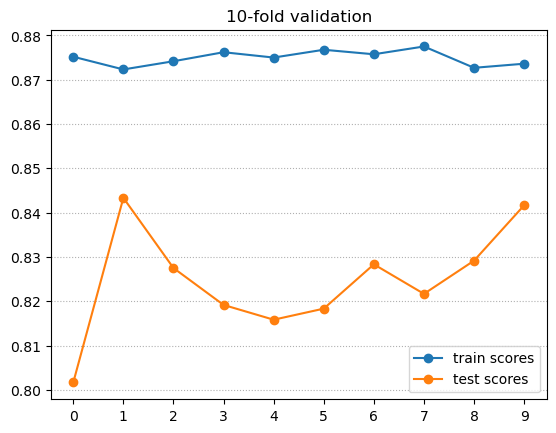

In [32]:
# plots the test and train scores for each split
output = cross_validate(clf, X_data, y_data, return_train_score = True, cv = 10)
plt.plot(range(10),output['train_score'], 'o-', label='train scores')
plt.plot(range(10),output['test_score'], 'o-', label='test scores')
plt.title('10-fold validation')
plt.xticks(range(10))
plt.grid(axis='y', linestyle='dotted')
plt.legend()

### Part B

**i) As in lec8_confusion.ipynb, print the `classification_report()` and use ConfusionMatrixDisplay to plot the (12x12) confusion matrix for the first split of the data (training set comprised of first 900 from all of the twelve classes, test set the latter 100 from all of them).**

In [35]:
# Create X_train and X_test
X_train = X_data[:900]
for i in range(1, 12):
    X_train = np.concatenate([X_train, X_data[1000*i:900+1000*i]])
X_test = X_data[900:1000]
for i in range(1,12):
    X_test = np.concatenate([X_test, X_data[900+1000*i:1000*(i+1)]])

# Create y_train and y_test
y_train = np.array([[i]*900 for i in range(12)]).flatten()
y_test = np.array([[i]*100 for i in range(12)]).flatten()

In [36]:
# Train clf on the train sets
clf.fit(X_train, y_train)

BernoulliNB(alpha=0.5)

In [37]:
# Classification report
print(classification_report(y_test, clf.predict(X_test), target_names = classnames))

                   precision    recall  f1-score   support

      astro-ph.IM       0.88      0.84      0.86       100
cond-mat.mes-hall       0.69      0.77      0.73       100
            cs.CV       0.91      0.85      0.88       100
            cs.HC       0.90      0.88      0.89       100
            cs.LG       0.77      0.86      0.82       100
           hep-ph       0.89      0.87      0.88       100
           hep-th       0.89      0.96      0.92       100
          math.AP       1.00      0.94      0.97       100
   physics.app-ph       0.72      0.66      0.69       100
  physics.comp-ph       0.75      0.83      0.79       100
         q-bio.NC       0.85      0.93      0.89       100
         quant-ph       0.91      0.71      0.80       100

         accuracy                           0.84      1200
        macro avg       0.85      0.84      0.84      1200
     weighted avg       0.85      0.84      0.84      1200



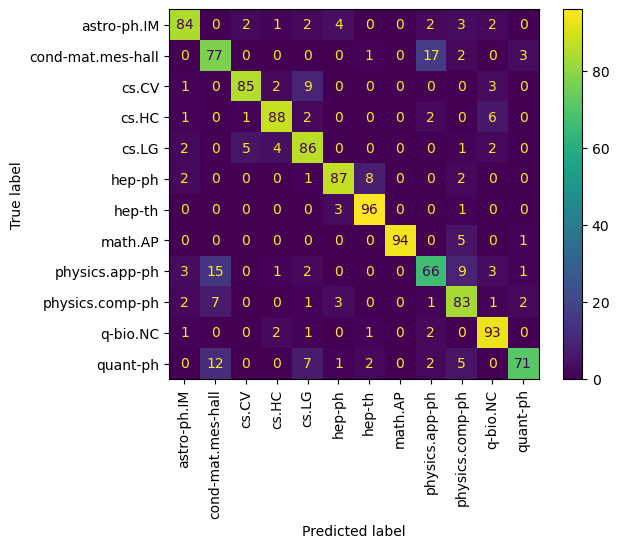

In [38]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels = classnames, xticks_rotation = 'vertical');

**ii) Plot the confusion matrix averaged over the ten cross-validation splits (again as in lec8_confusion.ipynb).**

In [40]:
X = np.array([features(txt) for subj in classnames for txt in absdata[subj]]) 
y = np.array([[i]*1000 for i in range(12)]).flatten()

In [41]:
clf = BernoulliNB(alpha = 0.5)
rskf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)
cmat = np.zeros([12, 12])

for train_index, test_index in rskf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train) 
    print(clf.score(X_test, y_test)) 
    cmat += confusion_matrix(y_test, clf.predict(X_test))

0.8458333333333333
0.8266666666666667
0.8391666666666666
0.83
0.8466666666666667
0.8283333333333334
0.8266666666666667
0.8425
0.8316666666666667
0.82


In [42]:
cmat /= 10
cmat

array([[82. ,  0. ,  1. ,  1.9,  2.6,  1.7,  0.2,  0. ,  2.8,  6.2,  1.2,
         0.4],
       [ 0.1, 77. ,  0.1,  0. ,  0. ,  0.4,  2.4,  0. , 13.9,  2.1,  0. ,
         4. ],
       [ 0.6,  0. , 86.9,  3.9,  6.4,  0. ,  0. ,  0. ,  0. ,  0.3,  1.9,
         0. ],
       [ 0.6,  0. ,  2.6, 90.6,  2.1,  0. ,  0. ,  0. ,  1.3,  0.2,  2.6,
         0. ],
       [ 0.7,  0. ,  8.6,  3.2, 79.2,  0. ,  0. ,  0.2,  0.1,  3.5,  3.8,
         0.7],
       [ 0.8,  1.1,  0.2,  0. ,  1.3, 86.3,  7.1,  0.1,  0.5,  2.2,  0.1,
         0.3],
       [ 0. ,  0.8,  0. ,  0. ,  0. ,  3.9, 93.2,  0.1,  0. ,  0.7,  0. ,
         1.3],
       [ 0. ,  0.2,  0. ,  0. ,  0.2,  0. ,  1.2, 94.1,  0.2,  2.9,  0.9,
         0.3],
       [ 2.1, 11.7,  0.1,  0.6,  0.5,  0.1,  0.3,  0.1, 75.5,  6.9,  1. ,
         1.1],
       [ 3.3,  5.8,  0.3,  0.3,  2.8,  0.8,  0.8,  0.9,  4.4, 77.4,  1.5,
         1.7],
       [ 0.6,  0.3,  1.1,  4.4,  2.6,  0.1,  0.3,  0.1,  1.2,  0.8, 87.4,
         1.1],
       [ 0.2,  8. ,  

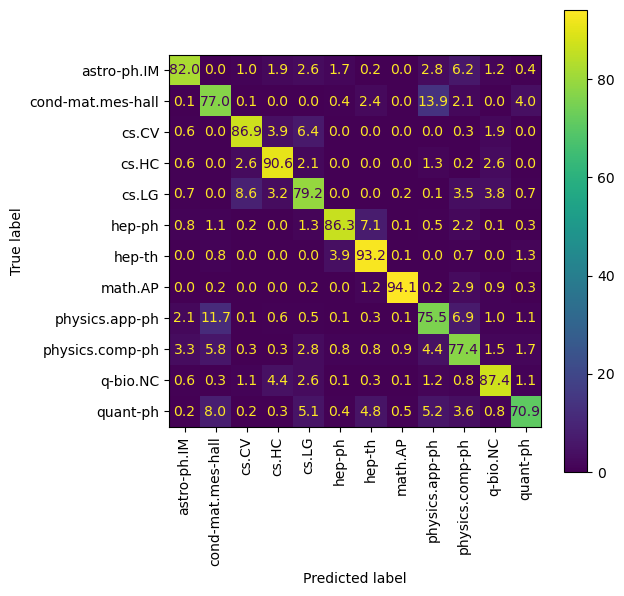

In [43]:
plt.figure(figsize=(6,6))
ConfusionMatrixDisplay(cmat, display_labels=classnames).plot(ax=plt.gca(), xticks_rotation='vertical', values_format='.1f');

## 3) MultinomialNB()

### Part A 
Use the same 2500 word vocabulary as in part 2A (it still makes sense to select words according to the percentage of documents in which they occur), and determine whether or not the mean 10-fold validation test score improves.

You can regenerate the X_data array using this new feature definition (y_data is unchanged), define a new clf = MultinomialNB() (it can just use its default alpha=1), and use the same call to cross_val_score() as before to calculate the mean test score over the 10-fold cross-validation splits. An argument for performing better is that it uses more information. An argument against is that the abstracts are typically short so there's not that much additional information in the word multiplicities (i.e., it might be more advantageous for longer texts).

In [46]:
def nfeatures(txt, Nf):
    f = np.zeros(Nf)
    count = Counter(words(txt))
    for w in set(count) & set_vocab: 
        f[word_index[w]] = count[w]
    return f  #array of number of times each feature occurs in txt

In [47]:
Nf = 2500

# sets up for X_data
word_index = {w:k for k,w in enumerate(feature_set)} # a dictionary where the value for each key is the index of that word in top_1000
set_vocab = set(feature_set)

# X_data is a feature set that uses features(txt) for texts in each subject of absdata
X_data = []
for subj in classnames:
    X_data += [nfeatures(txt, Nf) for txt in absdata[subj]]

# y_data is an array of (numeric) labels for each classname in absdata
y_data = np.array([[i]*1000 for i in range(12)]).flatten()

# define a new clf
clf = MultinomialNB(alpha = 1)

In [48]:
# Calculate the mean test score over the 10-fold cross-validation splits
output = cross_val_score(clf, X_data, y_data, cv = 10)
print(output.mean())

0.8373333333333333


The mean scores were very similar though the MultinomialNB model scored slightly higher than the BernoulliNB model. The score when using a BernoulliNB model was 82.5, and the score using a MultinomialNB model was 83.7

### Part B
As mentioned in class, the most 'confused' in part 2B are the four subject areas: cond-mat.mes-hall, physics.app-ph, physics.comp-ph, quant-ph. The full texts of these articles (rather than just abstracts) may provide a better setting for comparing BernoulliNB() and MultinomialNB(). This file ps2data.py.gz (or equivalently ps2data.zip) contains the full text of 2000 recent articles (i.e., up to this week), 500 from each of the subject areas. It can be unpacked as:

In [51]:
from ps2data import txtdata
classnames = sorted(txtdata)

for subj in classnames: 
    print(subj, len(txtdata[subj]))

cond-mat.mes-hall 500
physics.app-ph 500
physics.comp-ph 500
quant-ph 500


In [52]:
#see first 1500 characters of a full text
print(txtdata['physics.comp-ph'][0][:1500] + ' ...')

Cartesian atomic cluster expansion
for machine learning interatomic potentials
Bingqing Cheng1, 2 , "
1Department of Chemistry, University of California, Berkeley, CA, USA
2The Institute of Science and Technology Austria, Am Campus 1, 3400 Klosterneuburg, Austria
(Dated: February 13, 2024)

Machine learning interatomic potentials are revolutionizing large-scale, accurate atomistic mod-
elling in material science and chemistry. These potentials often use atomic cluster expansion or
equivariant message passing with spherical harmonics as basis functions. However, the dependence
on Clebsch-Gordan coefficients for maintaining rotational symmetry leads to computational ineffi-
ciencies and redundancies. We propose an alternative: a Cartesian-coordinates-based atomic density
expansion. This approach provides a complete description of atomic environments while maintaining
interaction body orders. Additionally, we integrate low-dimensional embeddings of various chemi-
cal elements and inter-a

Create feature sets for this data by first eliminating the words contained in at least 75% of the texts (i.e., 1500 of them). I found this meant eliminating the first 212 most common words, down to 'figure' (contained in 1500 of the texts). Then use the next Nf most common words as features, with the Nf in the range 2**np.arange(12):

In [54]:
# Create a dictionary with all the words in the most confused subject areas
vocab = {subj: Counter() for subj in classnames}
for subj in classnames:
  for txt in txtdata[subj]:
     for w in set(words(txt)): 
         vocab[subj][w] += 1

# Create a Counter to track the occurrences of all words in vocab
total_vocab = Counter()
for subj in classnames:
    total_vocab += vocab[subj]

print(total_vocab.most_common(5))
print(len(total_vocab))

[('to', 2000), ('4', 2000), ('on', 2000), ('b', 2000), ('3', 2000)]
263289


In [55]:
# Eliminate the words contained in at least 75% of them (1500 of them)
exclude_set = [w[0] for w in total_vocab.most_common() if w[1] >= 1500]
remaining = [w[0] for w in total_vocab.most_common() if w[1] < 1500]
print(len(exclude_set))

212


In [56]:
Nf = 2**np.arange(12)

feature_set = {}
for n in Nf:
    feature_set[n] = [w[0] for w in total_vocab.most_common() if w[0] in remaining[:n]]
    
#print(len(Nf) == len(feature_set)) # check to make sure there is a feature set for each Nf in the range 2**np.arange(12)

Implement Bernoulli and Multinomial Naive Bayes classfiers for this data, and plot the means of the 10-fold cross-validated train and test scores as functions of Nf over the above range (on the same plot, for comparison).

(Note you should only need to calculate the features once for the largest value 2048, then in your loop over Nf, just use the truncated data X_data[:,:Nf]

Your plot should be formatted as below (note however that the data itself plotted is entirely synthetic linear data, not necessarily expected to resemble your real data in any qualitative or quantitative way):

In [58]:
y_data = []
for i, subj in enumerate(classnames):
    for txt in txtdata[subj]:
        y_data.append(i)

y_data = np.array(y_data)

set_vocab = set(word for list in feature_set.values() for word in list)
word_index = {w:k for k,w in enumerate(feature_set[2048])}

In [59]:
def features(txt, Nf, word_index, set_vocab):
    f = np.zeros(Nf)
    for w in set(words(txt)) & set(set_vocab):
        f[word_index[w]] = 1
    return f

def nfeatures(txt, Nf):
    f = np.zeros(Nf)
    count = Counter(words(txt))
    for w in set(count) & set_vocab: 
        f[word_index[w]] = count[w]
    return f  #array of number of times each feature occurs in txt

In [60]:
b_train_scores = []
b_test_scores = []
multi_train_scores = []
multi_test_scores = []

X_data = np.array([features(txt, 2048, word_index, set_vocab) for subj in classnames for txt in txtdata[subj]])

for n in Nf:
    X_trunc_data = X_data[:,:n]
    #print(X_trunc_data.shape)
    
    bernoulli_clf = BernoulliNB(alpha = 0.5)
    bernoulli_train_score = cross_val_score(bernoulli_clf, X_trunc_data, y_data, cv = 10)
    bernoulli_test_score = cross_val_score(bernoulli_clf, X_trunc_data, y_data, cv = 10)
    
    b_train_scores.append(np.mean(bernoulli_train_score))
    b_test_scores.append(np.mean(bernoulli_test_score))

X_data = np.array([nfeatures(txt, 2048) for subj in classnames for txt in txtdata[subj]])
for n in Nf:
    X_trunc_data = X_data[:,:n]
    #print(X_trunc_data.shape)
    
    multi_clf = MultinomialNB(alpha = 0.5)
    multi_train_score = cross_val_score(multi_clf, X_trunc_data, y_data, cv = 10)
    multi_test_score = cross_val_score(multi_clf, X_trunc_data, y_data, cv = 10)
    
    multi_train_scores.append(np.mean(multi_train_score))
    multi_test_scores.append(np.mean(multi_test_score))

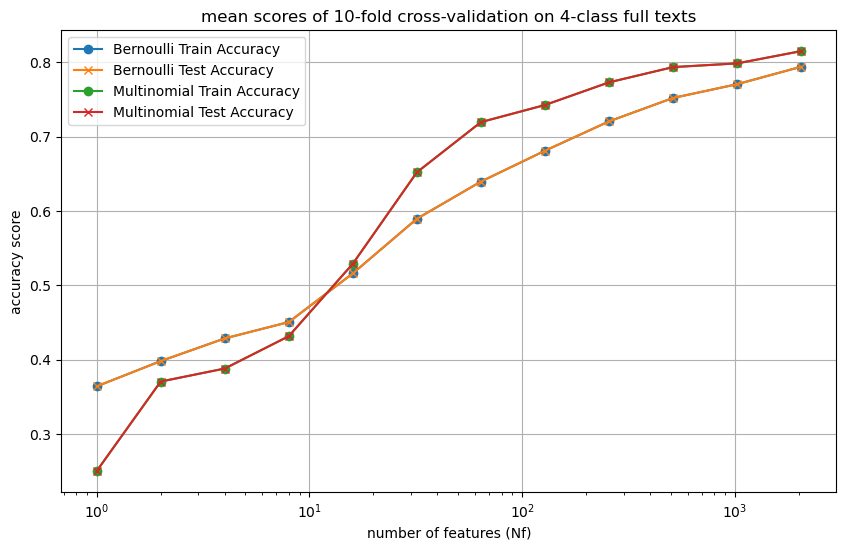

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(Nf, b_train_scores, label='Bernoulli Train Accuracy', marker='o')
plt.plot(Nf, b_test_scores, label='Bernoulli Test Accuracy', marker='x')
plt.plot(Nf, multi_train_scores, label='Multinomial Train Accuracy', marker='o')
plt.plot(Nf, multi_test_scores, label='Multinomial Test Accuracy', marker='x')
plt.xscale('log')
plt.xlabel('number of features (Nf)')
plt.ylabel('accuracy score')
plt.title('mean scores of 10-fold cross-validation on 4-class full texts')
plt.legend()
plt.grid(True)
plt.show()